# Understanding Monte Carlo Tree Search (MCTS): A Complete Guide

# Table of Contents

- [Introduction: Search and Planning in RL](#introduction)
- [What is MCTS?](#what-is-mcts)
  - [Core Idea: Guided Simulation](#core-idea)
  - [MCTS vs. Other Search Methods](#mcts-vs-other-search-methods)
- [Why MCTS? Advantages](#why-mcts)
- [Where and How MCTS is Used](#where-and-how-mcts-is-used)
- [Mathematical Foundation of MCTS](#mathematical-foundation-of-mcts)
  - [Tree Structure: Nodes and Edges](#tree-structure)
  - [The Four Steps of MCTS Iteration](#the-four-steps)
    - [1. Selection](#1-selection)
    - [2. Expansion](#2-expansion)
    - [3. Simulation (Rollout)](#3-simulation-rollout)
    - [4. Backpropagation](#4-backpropagation)
  - [Upper Confidence Bound for Trees (UCT/UCB1)](#uct-ucb1)
  - [Rollout Policy](#rollout-policy)
- [Step-by-Step Explanation of MCTS (for Action Selection)](#step-by-step-explanation-of-mcts)
- [Key Components of MCTS](#key-components-of-mcts)
  - [Tree Nodes](#tree-nodes)
  - [Selection Policy (UCB1)](#selection-policy-ucb1)
  - [Expansion Strategy](#expansion-strategy)
  - [Simulation (Rollout) Policy](#simulation-rollout-policy)
  - [Backpropagation Update](#backpropagation-update)
  - [Simulation Budget](#simulation-budget)
  - [Final Action Selection](#final-action-selection)
  - [Environment Model/Simulator](#environment-modelsimulator)
  - [Hyperparameters](#hyperparameters)
- [Practical Example: Custom Grid World](#practical-example-custom-grid-world)
  - [Why Grid World for MCTS?](#why-grid-world)
- [Setting up the Environment](#setting-up-the-environment)
- [Creating the Custom Environment](#creating-the-custom-environment)
- [Implementing the MCTS Algorithm](#implementing-the-mcts-algorithm)
  - [Defining the MCTS Node](#defining-the-mcts-node)
  - [Selection Function (Best UCB Child)](#selection-function-best-ucb-child)
  - [Expansion Function](#expansion-function)
  - [Simulation (Rollout) Function](#simulation-rollout-function)
  - [Backpropagation Function](#backpropagation-function)
  - [Main MCTS Search Function](#main-mcts-search-function)
  - [Choosing the Best Action After Search](#choosing-the-best-action-after-search)
- [Running MCTS as a Planner](#running-mcts-as-a-planner)
  - [Hyperparameter Setup](#hyperparameter-setup)
  - [Interaction Loop using MCTS](#interaction-loop-using-mcts)
- [Visualizing the Process](#visualizing-the-process)
  - [Visualizing an Agent's Path](#visualizing-an-agents-path)
- [Analyzing the Learned Policy (Optional Visualization)](#analyzing-the-learned-policy-optional-visualization)
- [Common Challenges and Extensions of MCTS](#common-challenges-and-extensions-of-mcts)
- [Conclusion](#conclusion)

## Introduction: Search and Planning in RL

While many Reinforcement Learning algorithms learn policies or value functions directly from experience (model-free), another powerful approach involves **planning**. Planning methods use a model of the environment (either known beforehand or learned) to simulate future possibilities and make informed decisions. Monte Carlo Tree Search (MCTS) is a highly successful planning algorithm that intelligently explores the potential future trajectories from the current state.

Unlike algorithms like DQN or PPO which produce a policy applicable to *any* encountered state, MCTS is typically used *online*. Given a current state, it performs a search to determine the best *immediate* action, then discards the search tree (mostly) and repeats the process from the next state.

## What is MCTS?

Monte Carlo Tree Search is a best-first search algorithm guided by the results of random simulations (Monte Carlo rollouts). It incrementally builds a search tree where nodes represent states and edges represent actions. It doesn't require an explicit evaluation function for states but instead estimates the value of states and actions within the tree based on the outcomes of simulations initiated from them.

### Core Idea: Guided Simulation
MCTS iteratively simulates trajectories through the state space. Instead of exploring randomly or exhaustively, it uses the statistics gathered from previous simulations (like visit counts and average rewards) to guide the search towards more promising areas of the state-action space while still ensuring some level of exploration.

### MCTS vs. Other Search Methods
- **vs. Minimax/Alpha-Beta:** MCTS doesn't require evaluating all possible game states up to a certain depth. It samples trajectories, making it suitable for domains with huge branching factors (like Go).
- **vs. Dynamic Programming:** DP requires a full model and iterates over the entire state space. MCTS focuses search effort starting from the current state and doesn't need global iterations.
- **vs. Model-Free RL:** MCTS is a planning algorithm that requires a model (or simulator access). Model-free RL learns directly from real interactions.

## Why MCTS? Advantages

1.  **Anytime Algorithm:** MCTS can be stopped at any time (given a computational budget) and will provide the best action found so far. More computation generally leads to better decisions.
2.  **Asymmetric Tree Growth:** It naturally focuses computational effort on more promising branches of the search tree.
3.  **No Heuristic Evaluation Function Needed (for search):** Node values are estimated via simulations, avoiding the need to hand-craft heuristics (though good rollout policies can help).
4.  **Parallelizable:** The independent simulations within an iteration can often be parallelized.

## Where and How MCTS is Used

MCTS gained widespread fame for its success in computer Go (AlphaGo, AlphaZero), but it's applicable to a wide range of problems:

1.  **Game Playing:** Go, Chess, Shogi, Hex, and many other board games, as well as video games.
2.  **Planning Problems:** Robotics, scheduling, general decision-making problems where a simulator is available.
3.  **Integration with Deep Learning:** AlphaGo/AlphaZero combined MCTS with deep neural networks (learned policy and value functions) to guide the search and evaluate positions, achieving superhuman performance.

MCTS is particularly effective when:
- The state space is large or infinite.
- The branching factor (number of possible actions) is large.
- A simulator or forward model of the environment is available.
- An exact evaluation function is unknown or hard to compute.
- Decisions need to be made online with a limited computational budget per decision.

## Mathematical Foundation of MCTS

### Tree Structure: Nodes and Edges
- **Nodes:** Represent states in the environment.
- **Edges:** Represent actions taken from a state (parent node) leading to a potential next state (child node).
- **Node Statistics:** Each node $s$ typically stores:
    - $N(s)$: Visit count (how many simulations passed through this node).
    - $W(s)$: Total accumulated reward (or value) from simulations passing through this node.
    - $Q(s) = W(s) / N(s)$: Average value estimate for the node.
- **Edge Statistics:** Each edge $(s, a)$ leading out of node $s$ may store:
    - $N(s, a)$: Visit count for taking action $a$ from state $s$.
    - $W(s, a)$: Total reward from simulations initiated after taking action $a$ from state $s$.
    - $Q(s, a) = W(s, a) / N(s, a)$: Average value estimate for taking action $a$ in state $s$.

### The Four Steps of MCTS Iteration
Each iteration of MCTS, starting from the root node (current state), consists of four phases:

1.  **Selection:**
    - Start at the root node.
    - Recursively select child nodes based on a tree policy that balances exploration and exploitation until a leaf node (a node not fully expanded or a terminal node) is reached.
    - A common tree policy is UCT (Upper Confidence Bound for Trees), based on UCB1.

2.  **Expansion:**
    - If the selected leaf node $L$ is not terminal and not fully expanded (i.e., there are untried actions from state $L$), choose one untried action $a$.
    - Simulate taking action $a$ using the environment model/simulator to get the next state $s'$.
    - Add a new child node representing $s'$ to the tree, connected to $L$ by the edge $a$.
    - The newly added node becomes the node for the Simulation phase.

3.  **Simulation (Rollout):**
    - From the newly expanded node (or the selected leaf node if it was terminal or fully expanded), simulate a complete episode (or until a maximum depth or discount horizon) using a *rollout policy* (often simple, e.g., random actions).
    - Collect the total discounted reward $R$ obtained during this simulation.

4.  **Backpropagation:**
    - Update the statistics ($N$ and $W$) of all nodes and edges visited during the Selection and Expansion phases using the simulation result $R$.
    - For each node $n$ on the path from the root to the simulated node:
        - Increment $N(n) \leftarrow N(n) + 1$.
        - Update $W(n) \leftarrow W(n) + R$ (or update based on whose turn it is in games).
    - Update edge statistics similarly if stored.

### Upper Confidence Bound for Trees (UCT/UCB1)
During the Selection phase, the action $a$ leading from node $s$ to child $s'$ is typically chosen to maximize the UCB1 formula:
$$ UCT(s, a) = Q(s, a) + C \sqrt{\frac{\ln N(s)}{N(s, a)}} $$
Where:
- $Q(s, a)$ is the current average value (exploitation term).
- $N(s)$ is the visit count of the parent node $s$.
- $N(s, a)$ is the visit count of the edge (or child node after taking action $a$).
- $C$ is an exploration constant (hyperparameter) balancing exploitation and exploration. Higher $C$ encourages exploring less visited actions.
If $N(s, a) = 0$, the UCB value is treated as infinite to ensure unvisited actions are selected first.

### Rollout Policy
The policy used during the Simulation phase. It should be computationally cheap. Common choices:
- **Random Policy:** Select actions uniformly at random.
- **Simple Heuristic:** A fast, problem-specific heuristic policy.
- **Learned Policy:** A lightweight policy learned separately (less common in basic MCTS).
The quality of the rollout policy affects the accuracy of the value estimates obtained from simulations.

## Step-by-Step Explanation of MCTS (for Action Selection)

Given a current state $s_{root}$ and a simulation budget (e.g., number of iterations $N_{sim}$):

1.  **Initialize**: Create a root node for $s_{root}$.
2.  **Loop** for $i = 1$ to $N_{sim}$:
    a.  **Selection**: Start from $s_{root}$. Traverse the tree using UCT to select actions until a leaf node $L$ is reached.
    b.  **Expansion**: If $L$ is expandable, choose an untried action $a$, create a new child node $C$ corresponding to the state resulting from $(L, a)$. Set the simulation start node to $C$.
    c.  If $L$ was already fully expanded or terminal, set the simulation start node to $L$.
    d.  **Simulation**: From the simulation start node's state, run a rollout using the rollout policy until termination or max depth. Record the total reward $R$.
    e.  **Backpropagation**: Update visit counts ($N$) and total values ($W$) for all nodes/edges on the path from the root to the simulation start node using the reward $R$.
3.  **Choose Action**: After $N_{sim}$ iterations, select the action $a^*$ corresponding to the edge from the root node with the highest visit count $N(s_{root}, a^*)$ (or sometimes highest value $Q(s_{root}, a^*)$).
4.  Return $a^*$.

## Key Components of MCTS

### Tree Nodes
- Store state, parent/child links, visit count $N$, total value $W$.

### Selection Policy (UCB1)
- Balances exploring less-visited actions and exploiting high-value actions during tree traversal.

### Expansion Strategy
- How new nodes are added (typically one per iteration for an untried action).

### Simulation (Rollout) Policy
- Fast policy used to estimate value from unexpanded nodes (e.g., random).

### Backpropagation Update
- How simulation results update node statistics.

### Simulation Budget
- Number of iterations/simulations performed per decision (controls thinking time).

### Final Action Selection
- How the best action is chosen after the search (e.g., most visited child).

### Environment Model/Simulator
- Needed to predict the outcome $(s', r)$ of taking action $a$ in state $s$ during Expansion and Simulation.

### Hyperparameters
- Exploration constant $C$ in UCB1.
- Simulation budget (iterations or time).
- Discount factor $\gamma$ (if rollouts are discounted).

## Practical Example: Custom Grid World

### Why Grid World for MCTS?
As discussed, the discrete state space, clear actions, and readily available perfect model (the environment code itself) make it ideal for illustrating the MCTS steps without confounding factors. We can see how the tree explores paths and uses simulated rewards to guide action selection.

**Environment Description:** (Using Tabular Version)
- State: `(row, col)` tuple.
- Actions: 0-3 (Up, Down, Left, Right).
- Dynamics: Deterministic transitions based on `action_map`.
- Rewards: +10 (goal), -1 (wall), -0.1 (step).


# Setting up the Environment

Import libraries. We primarily need `math`, `random`, `copy` (for simulation states), and `collections` or classes for the tree.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import copy # For deep copying states during simulation
from collections import defaultdict
from typing import Tuple, Dict, Any, List, Optional, Set

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)

%matplotlib inline

# Creating the Custom Environment

Using the `GridEnvironmentTabular` class.

In [2]:
class GridEnvironmentTabular:
    """ Grid World returning state tuples, with added state copy method. """
    def __init__(self, rows: int = 10, cols: int = 10) -> None:
        self.rows: int = rows
        self.cols: int = cols
        self.start_state: Tuple[int, int] = (0, 0)
        self.goal_state: Tuple[int, int] = (rows - 1, cols - 1)
        # Internal state variable - MCTS will operate on copies
        self._internal_state: Tuple[int, int] = self.start_state 
        self.action_dim: int = 4
        self.action_map: Dict[int, Tuple[int, int]] = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)}
        self.actions = list(self.action_map.keys())

    def reset(self) -> Tuple[int, int]:
        """ Resets environment, returns state tuple. """
        self._internal_state = self.start_state
        return self._internal_state

    def get_state(self) -> Tuple[int, int]:
        """ Returns the current internal state tuple. """
        return self._internal_state
        
    def set_state(self, state: Tuple[int, int]) -> None:
        """ Manually sets the internal state (for MCTS simulation). """
        if 0 <= state[0] < self.rows and 0 <= state[1] < self.cols:
            self._internal_state = state
        else:
            raise ValueError(f"Invalid state {state} for grid size {self.rows}x{self.cols}")

    def get_possible_actions(self, state: Optional[Tuple[int, int]] = None) -> List[int]:
            """ Returns a list of possible actions from the given state (or current). """
            # In this simple grid, all actions are always possible (walls handled in step)
            current_state = state if state is not None else self._internal_state
            if current_state == self.goal_state:
                return [] # No actions from goal state
            return [action for action in self.actions if self.simulate_step(current_state, action)[0] != current_state]
            
    def is_terminal(self, state: Optional[Tuple[int, int]] = None) -> bool:
        """ Checks if the given state (or current) is terminal. """
        current_state = state if state is not None else self._internal_state
        return current_state == self.goal_state

    def step(self, action: int) -> Tuple[Tuple[int, int], float, bool]:
        """ Performs one step from the current internal state. """
        state = self._internal_state # Use internal state
        if state == self.goal_state:
            return state, 0.0, True
        
        dr, dc = self.action_map[action]
        current_row, current_col = state
        next_row, next_col = current_row + dr, current_col + dc
        
        reward: float = -0.1 # Step cost
        if not (0 <= next_row < self.rows and 0 <= next_col < self.cols):
            next_row, next_col = current_row, current_col # Stay in place
            reward = -1.0 # Wall penalty
            
        self._internal_state = (next_row, next_col) # Update internal state
        next_state_tuple = self._internal_state
        
        done: bool = (self._internal_state == self.goal_state)
        if done:
            reward = 10.0 # Goal reward
            
        return next_state_tuple, reward, done

    def simulate_step(self, current_state: Tuple[int, int], action: int) -> Tuple[Tuple[int, int], float, bool]:
        """ Simulates a step WITHOUT changing the internal state. Needed for MCTS. """
        if current_state == self.goal_state:
            return current_state, 0.0, True
        
        dr, dc = self.action_map[action]
        current_row, current_col = current_state
        next_row, next_col = current_row + dr, current_col + dc
        
        reward: float = -0.1
        if not (0 <= next_row < self.rows and 0 <= next_col < self.cols):
            next_state_tuple = current_state # Return original state if wall hit
            reward = -1.0
        else:
            next_state_tuple = (next_row, next_col)
        
        done: bool = (next_state_tuple == self.goal_state)
        if done:
            reward = 10.0
            
        return next_state_tuple, reward, done

    def get_action_space_size(self) -> int:
        return self.action_dim

Instantiate the environment.

In [3]:
mcts_env = GridEnvironmentTabular(rows=5, cols=5) # Use a smaller grid for faster MCTS demo
n_actions_mcts = mcts_env.get_action_space_size()
start_state_mcts = mcts_env.reset()
print(f"MCTS Grid Environment: {mcts_env.rows}x{mcts_env.cols}")
print(f"Actions: {n_actions_mcts}")
print(f"Start State: {start_state_mcts}")
print(f"Goal State: {mcts_env.goal_state}")

MCTS Grid Environment: 5x5
Actions: 4
Start State: (0, 0)
Goal State: (4, 4)


# Implementing the MCTS Algorithm

We'll define the Node structure and the four key functions: Selection, Expansion, Simulation, Backpropagation, plus the main search orchestrator.

### Defining the MCTS Node

A class to represent nodes in the search tree.

In [4]:
class MCTSNode:
    """ Represents a node in the Monte Carlo Tree Search. """
    def __init__(self, state: Tuple[int, int], parent: Optional['MCTSNode'] = None, action_that_led_here: Optional[int] = None):
        self.state: Tuple[int, int] = state
        self.parent: Optional[MCTSNode] = parent
        self.action_that_led_here: Optional[int] = action_that_led_here # Action taken by parent to reach this node
        
        self.children: Dict[int, MCTSNode] = {} # Maps action -> child node
        self.untried_actions: List[int] = mcts_env.get_possible_actions(state) # Actions not yet expanded from this node
        
        self.visit_count: int = 0
        self.total_value: float = 0.0 # Sum of rewards from rollouts through this node
        
    def is_fully_expanded(self) -> bool:
        """ Checks if all possible actions from this node have been expanded. """
        return len(self.untried_actions) == 0
        
    def is_terminal(self) -> bool:
        """ Checks if the state represented by this node is terminal. """
        return mcts_env.is_terminal(self.state)
        
    def get_average_value(self) -> float:
        """ Calculates the average value Q(s) for this node. """
        if self.visit_count == 0:
            return 0.0 # Or perhaps -infinity or another default for unvisited
        return self.total_value / self.visit_count

### Selection Function (Best UCB Child)

Selects the child node with the highest UCT value.

In [5]:
def select_best_child_uct(node: MCTSNode, exploration_constant: float) -> MCTSNode:
    """
    Selects the child node with the highest UCT score.
    UCT = Q(child) + C * sqrt(ln(N(parent)) / N(child))
    
    Parameters:
    - node (MCTSNode): The parent node from which to select.
    - exploration_constant (float): The constant C balancing exploration/exploitation.
    
    Returns:
    - MCTSNode: The child node with the highest UCT value.
    """
    best_score = -float('inf')
    best_child = None

    for action, child in node.children.items():
        if child.visit_count == 0:
            # Ensure unvisited children are selected first
            uct_score = float('inf') 
        else:
            exploit_term = child.get_average_value()
            explore_term = exploration_constant * math.sqrt(
                math.log(node.visit_count) / child.visit_count
            )
            uct_score = exploit_term + explore_term
            
        if uct_score > best_score:
            best_score = uct_score
            best_child = child
            
    if best_child is None:
        # This should ideally not happen if the node has children
        raise RuntimeError("Selection failed: No children found or error in UCT calculation.")

    return best_child

### Expansion Function

Expands a leaf node by adding one new child node for an untried action.

In [6]:
def expand_node(node: MCTSNode) -> MCTSNode:
    """
    Expands the given node by choosing an untried action, simulating it,
    and adding the resulting state as a new child node.

    Parameters:
    - node (MCTSNode): The leaf node to expand.

    Returns:
    - MCTSNode: The newly created child node.
    """
    if not node.untried_actions:
        raise RuntimeError("Cannot expand a fully expanded node.")
        
    # Choose an action to expand (e.g., the first untried one)
    action = node.untried_actions.pop() 
    
    # Simulate this action from the node's state using the environment model
    next_state, _, _ = mcts_env.simulate_step(node.state, action) # We only need next state here
    
    # Create the new child node
    child_node = MCTSNode(state=next_state, parent=node, action_that_led_here=action)
    
    # Add the child to the parent's children dictionary
    node.children[action] = child_node
    
    return child_node

### Simulation (Rollout) Function

Simulates an episode from a given state using a simple rollout policy (random actions).

In [7]:
def perform_rollout(start_node: MCTSNode, max_depth: int, gamma: float) -> float:
    """
    Performs a Monte Carlo simulation (rollout) from the start node's state.
    Uses a random policy for the rollout.

    Parameters:
    - start_node (MCTSNode): The node from which to start the simulation.
    - max_depth (int): Maximum number of steps for the rollout.
    - gamma (float): Discount factor for the rollout rewards.

    Returns:
    - float: The total discounted reward obtained during the rollout.
    """
    current_state = start_node.state
    total_discounted_reward: float = 0.0
    current_discount: float = 1.0
    depth = 0

    while not mcts_env.is_terminal(current_state) and depth < max_depth:
        # Choose a random action (rollout policy)
        possible_actions = mcts_env.get_possible_actions(current_state)
        if not possible_actions: # Should not happen if not terminal, but safe check
            break 
        action = random.choice(possible_actions)
        
        # Simulate the step using the environment model
        next_state, reward, done = mcts_env.simulate_step(current_state, action)
        
        total_discounted_reward += current_discount * reward
        
        current_state = next_state
        current_discount *= gamma
        depth += 1
        
    return total_discounted_reward

### Backpropagation Function

Updates the statistics of nodes along the path from the root to the simulation node.

In [8]:
def backpropagate(node: MCTSNode, reward: float) -> None:
    """
    Updates the visit counts and total values of nodes up the tree.

    Parameters:
    - node (MCTSNode): The node from which the simulation started.
    - reward (float): The result (total discounted reward) of the simulation.
    """
    current_node: Optional[MCTSNode] = node
    while current_node is not None:
        current_node.visit_count += 1
        current_node.total_value += reward 
        # Move up to the parent node
        current_node = current_node.parent

### Main MCTS Search Function

Orchestrates the four steps for a given number of iterations.

In [9]:
def mcts_search(
    root_state: Tuple[int, int],
    num_simulations: int,
    exploration_constant: float,
    rollout_max_depth: int,
    gamma: float
) -> MCTSNode:
    """
    Performs the Monte Carlo Tree Search (MCTS) process for a given number of simulations.

    Parameters:
    - root_state (Tuple[int, int]): The starting state for the search.
    - num_simulations (int): The number of simulations to perform.
    - exploration_constant (float): The exploration constant (C) used in the UCT formula.
    - rollout_max_depth (int): The maximum depth for rollouts during the simulation phase.
    - gamma (float): The discount factor for rewards during rollouts.

    Returns:
    - MCTSNode: The root node of the search tree after simulations.
    """
    # Create the root node for the current state
    root_node: MCTSNode = MCTSNode(state=root_state)

    # Perform the specified number of simulations
    for _ in range(num_simulations):
        current_node: MCTSNode = root_node

        # --- 1. Selection ---
        # Traverse down the tree using UCT until a leaf node is found
        while not current_node.is_terminal() and current_node.is_fully_expanded() and current_node.children:
            current_node = select_best_child_uct(current_node, exploration_constant)

        # --- 2. Expansion ---
        # Expand the current node if it is not terminal and not fully expanded
        simulation_start_node: MCTSNode = current_node
        if not current_node.is_terminal() and not current_node.is_fully_expanded():
            simulation_start_node = expand_node(current_node)

        # --- 3. Simulation ---
        # Perform a rollout from the expanded node and calculate the reward
        rollout_reward: float = perform_rollout(simulation_start_node, rollout_max_depth, gamma)

        # --- 4. Backpropagation ---
        # Update the statistics of all nodes along the path to the root
        backpropagate(simulation_start_node, rollout_reward)

    # Return the root node with updated statistics
    return root_node

### Choosing the Best Action After Search

Selects the best action based on the statistics in the tree (e.g., most visited child).

In [10]:
def choose_best_mcts_action(root_node: MCTSNode) -> int:
    """
    Selects the best action from the root node after MCTS is complete.
    Typically chooses the action leading to the most visited child node.

    Parameters:
    - root_node (MCTSNode): The root of the search tree after simulations.

    Returns:
    - int: The best action to take.
    """
    best_visit_count = -1
    best_action = -1

    if not root_node.children:  # If no actions were expanded (e.g., only 1 simulation)
        # Fallback: Choose a random action if possible
        possible_actions = mcts_env.get_possible_actions(root_node.state)
        if possible_actions:
            return random.choice(possible_actions)
        else:
            return -1  # Or handle error

    # Find the action leading to the child with the highest visit count
    for action, child in root_node.children.items():
        if child.visit_count > best_visit_count:
            best_visit_count = child.visit_count
            best_action = action

    if best_action == -1:
        # Fallback if all children have 0 visits (shouldn't happen with proper MCTS)
        possible_actions = list(root_node.children.keys())
        if possible_actions:
            return random.choice(possible_actions)
        else:
            return -1

    return best_action

# Running MCTS as a Planner

We simulate an agent acting in the environment. At each step, it uses MCTS to decide the next action.

### Hyperparameter Setup

Define MCTS hyperparameters.

In [11]:
# Hyperparameters for MCTS on Custom Grid World
NUM_SIMULATIONS = 100       # MCTS iterations per action selection (budget)
EXPLORATION_C = 1.414       # UCT exploration constant (sqrt(2) is common)
ROLLOUT_MAX_DEPTH = 50      # Max steps during the simulation phase
GAMMA_MCTS = 0.99           # Discount factor for rollout rewards

NUM_EPISODES_MCTS = 50      # Number of episodes to run the agent for visualization
MAX_STEPS_PER_EPISODE_MCTS = 200 # Max steps per episode

### Interaction Loop using MCTS

The main loop where the agent interacts with the environment, using MCTS at each step.

In [12]:
print(f"Starting MCTS Agent Interaction (Simulations per step={NUM_SIMULATIONS})...")

# --- MCTS Interaction Loop ---
mcts_run_rewards = []
mcts_run_lengths = []

for i_episode in range(1, NUM_EPISODES_MCTS + 1):
    state: Tuple[int, int] = mcts_env.reset()
    episode_reward: float = 0.0
    episode_path: List[Tuple[int, int]] = [state] # Store path for visualization
    
    for t in range(MAX_STEPS_PER_EPISODE_MCTS):
        if mcts_env.is_terminal(state):
            break # Already at goal
        
        # --- Use MCTS to choose the best action --- 
        root_node = mcts_search(state, NUM_SIMULATIONS, EXPLORATION_C, 
                                ROLLOUT_MAX_DEPTH, GAMMA_MCTS)
        action = choose_best_mcts_action(root_node)
        # --- ------------------------------------ ---
        
        if action == -1: # Should not happen in this grid world unless goal reached
            print(f"Warning: MCTS returned invalid action (-1) at state {state}.")
            break

        # Take the chosen action in the real environment
        next_state, reward, done = mcts_env.step(action) # Use step() to advance env state
        
        state = next_state
        episode_reward += reward
        episode_path.append(state)
        
        if done:
            break
            
    # --- End of Episode --- 
    mcts_run_rewards.append(episode_reward)
    mcts_run_lengths.append(t + 1)
    
    # Print progress
    if i_episode % 10 == 0:
        avg_reward = np.mean(mcts_run_rewards[-10:])
        avg_length = np.mean(mcts_run_lengths[-10:])
        print(f"Episode {i_episode}/{NUM_EPISODES_MCTS} | Avg Reward (last 10): {avg_reward:.2f} | Avg Length: {avg_length:.1f}")

print("MCTS Agent Interaction Finished.")

Starting MCTS Agent Interaction (Simulations per step=100)...
Episode 10/50 | Avg Reward (last 10): 6.64 | Avg Length: 34.6
Episode 20/50 | Avg Reward (last 10): 6.80 | Avg Length: 33.0
Episode 30/50 | Avg Reward (last 10): 6.54 | Avg Length: 35.6
Episode 40/50 | Avg Reward (last 10): 3.21 | Avg Length: 58.8
Episode 50/50 | Avg Reward (last 10): 7.50 | Avg Length: 26.0
MCTS Agent Interaction Finished.


# Visualizing the Process

Plot the episode rewards and lengths achieved by the agent using MCTS for planning.

### Visualizing an Agent's Path
We can also plot the path taken in the last episode.

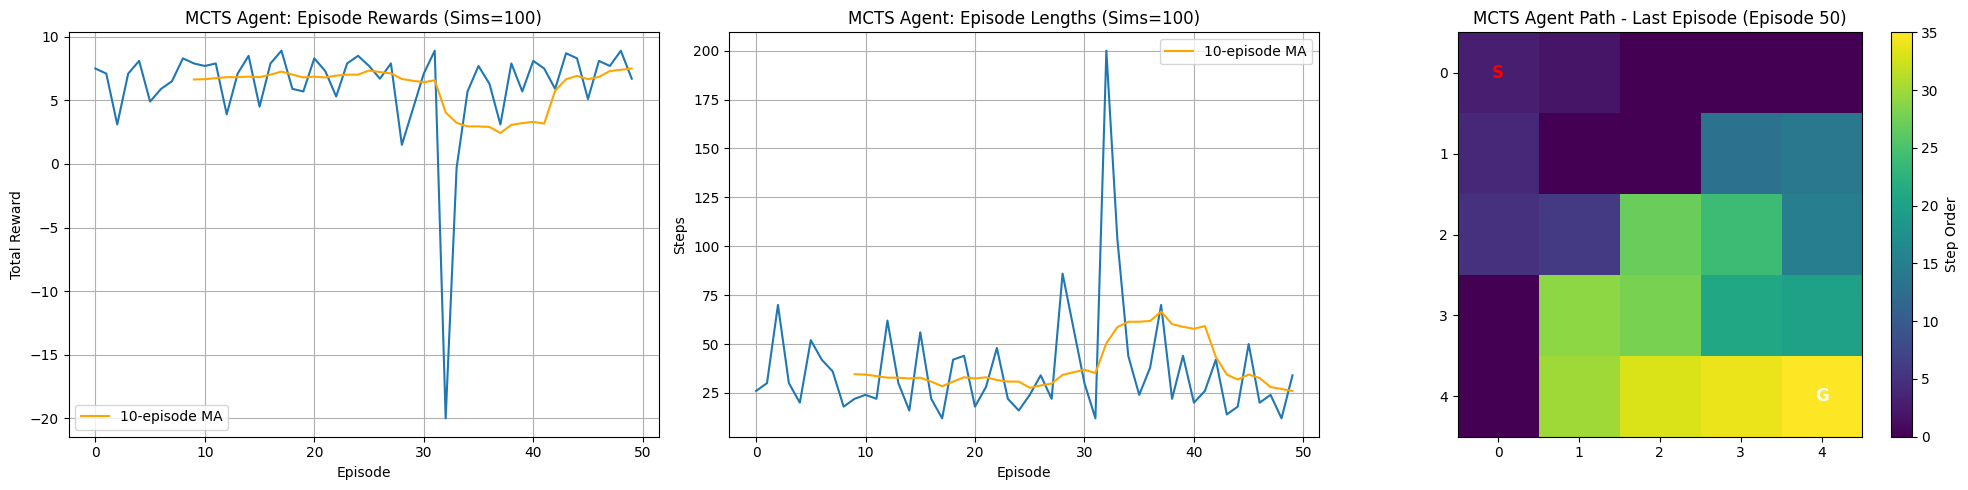

In [13]:
# Plotting results for MCTS Agent Runs
plt.figure(figsize=(20, 5))

# Rewards
plt.subplot(1, 3, 1)
plt.plot(mcts_run_rewards)
plt.title(f'MCTS Agent: Episode Rewards (Sims={NUM_SIMULATIONS})')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
if len(mcts_run_rewards) >= 10:
    rewards_ma_mcts = np.convolve(mcts_run_rewards, np.ones(10)/10, mode='valid')
    plt.plot(np.arange(len(rewards_ma_mcts)) + 9, rewards_ma_mcts, label='10-episode MA', color='orange')
    plt.legend()

# Lengths
plt.subplot(1, 3, 2)
plt.plot(mcts_run_lengths)
plt.title(f'MCTS Agent: Episode Lengths (Sims={NUM_SIMULATIONS})')
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.grid(True)
if len(mcts_run_lengths) >= 10:
    lengths_ma_mcts = np.convolve(mcts_run_lengths, np.ones(10)/10, mode='valid')
    plt.plot(np.arange(len(lengths_ma_mcts)) + 9, lengths_ma_mcts, label='10-episode MA', color='orange')
    plt.legend()

# Path Visualization
plt.subplot(1, 3, 3)
if 'episode_path' in locals() and episode_path:
    rows = mcts_env.rows
    cols = mcts_env.cols
    path_grid = np.zeros((rows, cols))
    for i, (r, c) in enumerate(episode_path):
        path_grid[r, c] = i + 1 # Mark path order
        
    plt.imshow(path_grid, cmap='viridis')
    plt.title(f"MCTS Agent Path - Last Episode (Episode {NUM_EPISODES_MCTS})")
    plt.colorbar(label='Step Order')
    
    # Mark start and goal
    start_r, start_c = mcts_env.start_state
    goal_r, goal_c = mcts_env.goal_state
    plt.text(start_c, start_r, 'S', ha='center', va='center', color='red', weight='bold', fontsize=12)
    plt.text(goal_c, goal_r, 'G', ha='center', va='center', color='white', weight='bold', fontsize=12)
else:
    plt.text(0.5, 0.5, "No path data available to visualize.", ha='center', va='center')
    plt.axis('off')

plt.tight_layout()
plt.show()


**Analysis of MCTS Agent Curves (Grid World, Sims=100):**

1.  **Episode Rewards & Lengths:**
    The agent generally achieves high rewards and finds relatively short paths, as indicated by the moving averages settling near the optimal reward range and low step counts (~20-25). However, both metrics show significant episode-to-episode volatility (e.g., the large reward dip and corresponding length spike around episode 32). This variance is characteristic of MCTS, as it relies on stochastic simulations within its planning phase at each step, rather than converging stable learned values like Q-learning.

2.  **Agent Path (Last Episode):**
    The visualized path for the final episode confirms that MCTS finds a successful path to the goal. However, the path taken (34 steps in this case for a 5x5 grid where optimal is 8) is clearly suboptimal. This highlights that while MCTS can solve the problem, the quality of the path found in any single episode depends heavily on the search performed *during that episode*, and it doesn't guarantee finding the globally shortest path consistently without a very large number of simulations.

**Overall Conclusion:**
MCTS, functioning as a planning algorithm using 100 simulations per step, effectively finds goal-reaching policies in the Grid World on average. Its performance is strong but exhibits higher variance and less consistent path optimality compared to value/policy *learning* methods. This demonstrates MCTS's strength in leveraging a model (implicit simulator) for planning but also its sensitivity to the stochasticity and budget of its search process within each episode.


Plotting MCTS Derived Policy (takes time):
Deriving policy grid (this might take a while)...
  Row 1/5 complete.
  Row 2/5 complete.
  Row 3/5 complete.
  Row 4/5 complete.
  Row 5/5 complete.


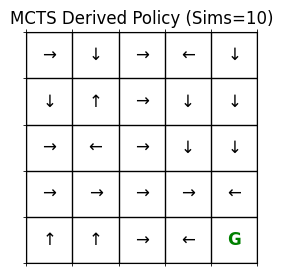

In [14]:
def plot_mcts_derived_policy(env: GridEnvironmentTabular,
                             num_simulations: int, 
                             exploration_constant: float, 
                             rollout_max_depth: int, 
                             gamma: float) -> None:
    """ Derives and plots the policy by running MCTS from each state. """
    rows: int = env.rows
    cols: int = env.cols
    policy_grid: np.ndarray = np.empty((rows, cols), dtype=str)
    action_symbols: Dict[int, str] = {0: '↑', 1: '↓', 2: '←', 3: '→'}

    print("Deriving policy grid (this might take a while)...")
    fig, ax = plt.subplots(figsize=(cols * 0.6, rows * 0.6))

    for r in range(rows):
        for c in range(cols):
            state: Tuple[int, int] = (r, c)
            if env.is_terminal(state):
                policy_grid[r, c] = 'G'
                ax.text(c, r, 'G', ha='center', va='center', color='green', fontsize=12, weight='bold')
            else:
                # Run MCTS from this state to find the best action
                root_node = mcts_search(state, num_simulations, exploration_constant, 
                                        rollout_max_depth, gamma)
                best_action = choose_best_mcts_action(root_node)
                
                if best_action != -1:
                    symbol = action_symbols[best_action]
                else: # Should only happen if state has no possible actions (not the case here except goal)
                    symbol = '?' 
                    
                policy_grid[r, c] = symbol
                ax.text(c, r, symbol, ha='center', va='center', color='black', fontsize=12)
        print(f"  Row {r+1}/{rows} complete.") # Progress indicator

    ax.matshow(np.zeros((rows, cols)), cmap='Greys', alpha=0.1)
    ax.set_xticks(np.arange(-.5, cols, 1), minor=True)
    ax.set_yticks(np.arange(-.5, rows, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"MCTS Derived Policy (Sims={num_simulations})")
    plt.show()

# Plot the derived policy (might be slow for large grids/simulations)
print("\nPlotting MCTS Derived Policy (takes time):")
plot_mcts_derived_policy(mcts_env, NUM_SIMULATIONS // 10, EXPLORATION_C, 
                         ROLLOUT_MAX_DEPTH // 2, GAMMA_MCTS) # Use fewer sims for faster plotting

## Common Challenges and Extensions of MCTS

**Challenge: Computational Cost**
*   **Problem:** Running many simulations per step can be computationally intensive, limiting real-time application.
*   **Solutions**:
    *   **Parallelization:** Run simulations in parallel (on multiple cores/machines).
    *   **Budget Tuning:** Adjust the number of simulations based on available time.
    * **Better Rollout Policies:** More informed rollout policies can lead to better value estimates with fewer simulations.
    * **Function Approximation (e.g., AlphaZero):** Use neural networks to provide prior probabilities for action selection (guiding the search) and to evaluate leaf nodes directly, reducing the need for deep rollouts.

**Challenge: High Branching Factor**
*   **Problem:** If there are many possible actions at each state, exploring them all during expansion becomes difficult.
   **Solutions**:
    *   **Progressive Widening (UCT for Continuous Actions):** Limit the number of actions expanded at a node based on visit counts.
    *   **Policy Guidance:** Use a learned policy network (like in AlphaZero) to suggest promising actions to explore first.

**Challenge: Simulation Quality**
*   **Problem:** The accuracy of MCTS relies on the value estimates from rollouts. Random rollouts can be very high variance, especially in environments with sparse rewards or long horizons.
   **Solutions**:
    *   **Domain-Specific Rollout Policies:** Incorporate simple heuristics if available.
    *   **Value Network Integration:** Evaluate leaf nodes using a learned value function instead of performing full rollouts.

**Challenge: Large State Spaces**
*   **Problem:** In very large or continuous state spaces, representing the tree explicitly becomes infeasible, and the same state might rarely be visited twice.
   **Solutions**:
    *   **State Abstraction/Discretization:** Group similar states (can lose information).
    *   **Function Approximation:** Use neural networks to represent policy/value estimates within the MCTS framework (e.g., AlphaZero, MuZero).

**Extensions:**
- **RAVE (Rapid Action Value Estimation):** Uses statistics from sibling nodes to improve value estimates.
- **Progressive Widening:** Handles large/continuous action spaces.
- **AlphaGo/AlphaZero/MuZero:** Combine MCTS with deep neural networks for policy and value estimation, and potentially model learning.

## Conclusion

Monte Carlo Tree Search (MCTS) is a powerful online planning algorithm that effectively balances exploration and exploitation to find good actions in complex decision-making problems. By iteratively building a search tree guided by simulated outcomes (rollouts), it can handle large state spaces and branching factors without requiring an explicit heuristic evaluation function.

Its success, particularly in game playing like Go, highlights its strength in domains where a simulator is available. While basic MCTS uses random rollouts, its true power often emerges when combined with domain knowledge or learned components (like policy and value networks in AlphaZero) to guide the search and simulations more effectively. Understanding MCTS provides a foundation for tackling complex planning problems and appreciating the synergy between search, simulation, and learning in artificial intelligence.